# Feature selection

This notebook contains the simple examples of using feature extractor transforms with ETNA library.

### Navigation

- [Intro](#20-intro-to-feature-selection)
- [TreeFeatureSelectionTransform](#21-tree)
- [GaleShapleyFeatureSelectionTransform](#21-galeshapleyfeatureselectiontransform)
- [MRMRFeatureSelectionTransform](#22-mrmrfeatureselectiontransform)


In [1]:
import warnings

warnings.filterwarnings("ignore")

## 1. Load Dataset

We are going to work with the time series from Tabular Playground Series - Jan 2022. The dataset contains daily merchandise sales – mugs, hats, and stickers – at two imaginary store chains across three Scandinavian countries. As exogenous data, we will use Finland, Norway, and Sweden Weather Data 2015-2019 dataset containing daily country average precipitation, snow depth and air temperature data.

In [2]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv("data/nordic_merch_sales.csv")

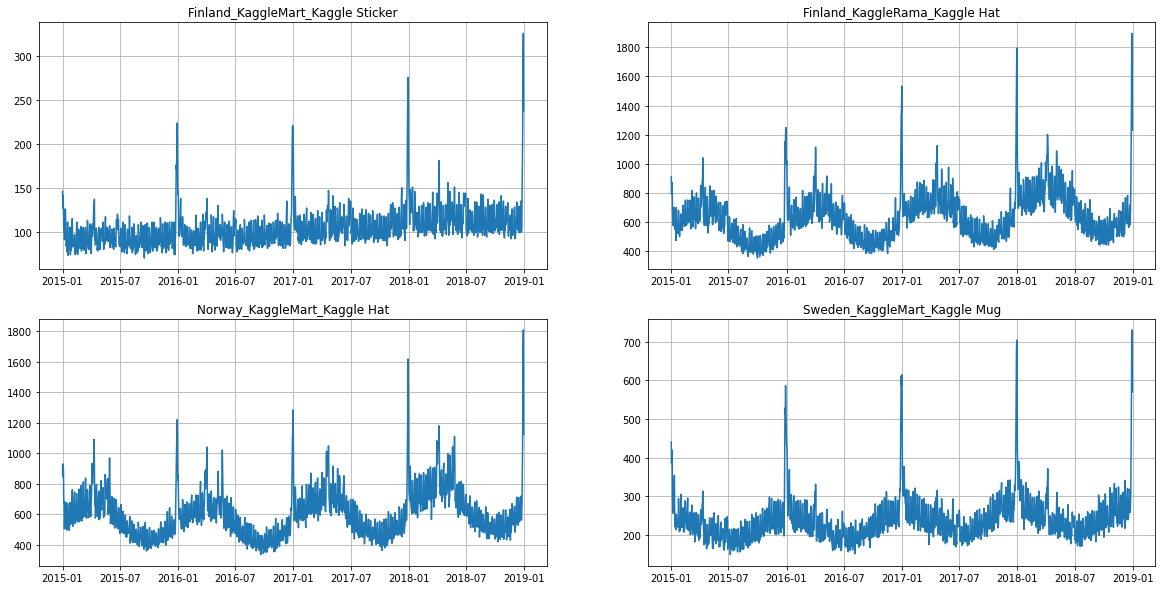

In [3]:
from etna.datasets import TSDataset

df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot(4)

In [4]:
HORIZON = 60

## 2. Feature selection methods

### 2.0 Intro to feature selection

Let's create features and build pipeline with dataset:

In [10]:
from etna.pipeline import Pipeline
from etna.models import CatBoostModelPerSegment
from etna.transforms import (
    DateFlagsTransform,
    MeanTransform,
    LagTransform,
    TrendTransform,
    FourierTransform,
    HolidayTransform,
)
from etna.metrics import SMAPE

transforms = [
    TrendTransform(in_column="target", out_column="trend"),
    LagTransform(in_column="target", lags=range(HORIZON, 100), out_column="target_lag"),
    DateFlagsTransform(
        day_number_in_month=True, day_number_in_week=False, is_weekend=False, out_column="datetime_flag"
    ),
    MeanTransform(in_column=f"target_lag_{HORIZON}", window=12, seasonality=7, out_column="mean_transform"),
    FourierTransform(period=250, order=6, out_column="fourier"),
    HolidayTransform(iso_code="SWE", out_column="SWE_holidays"),
    HolidayTransform(iso_code="NOR", out_column="NOR_holidays"),
    HolidayTransform(iso_code="FIN", out_column="FIN_holidays"),
]

pipeline = Pipeline(model=CatBoostModelPerSegment(), transforms=transforms, horizon=HORIZON)

metrics_baseline, forecast_baseline, _ = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


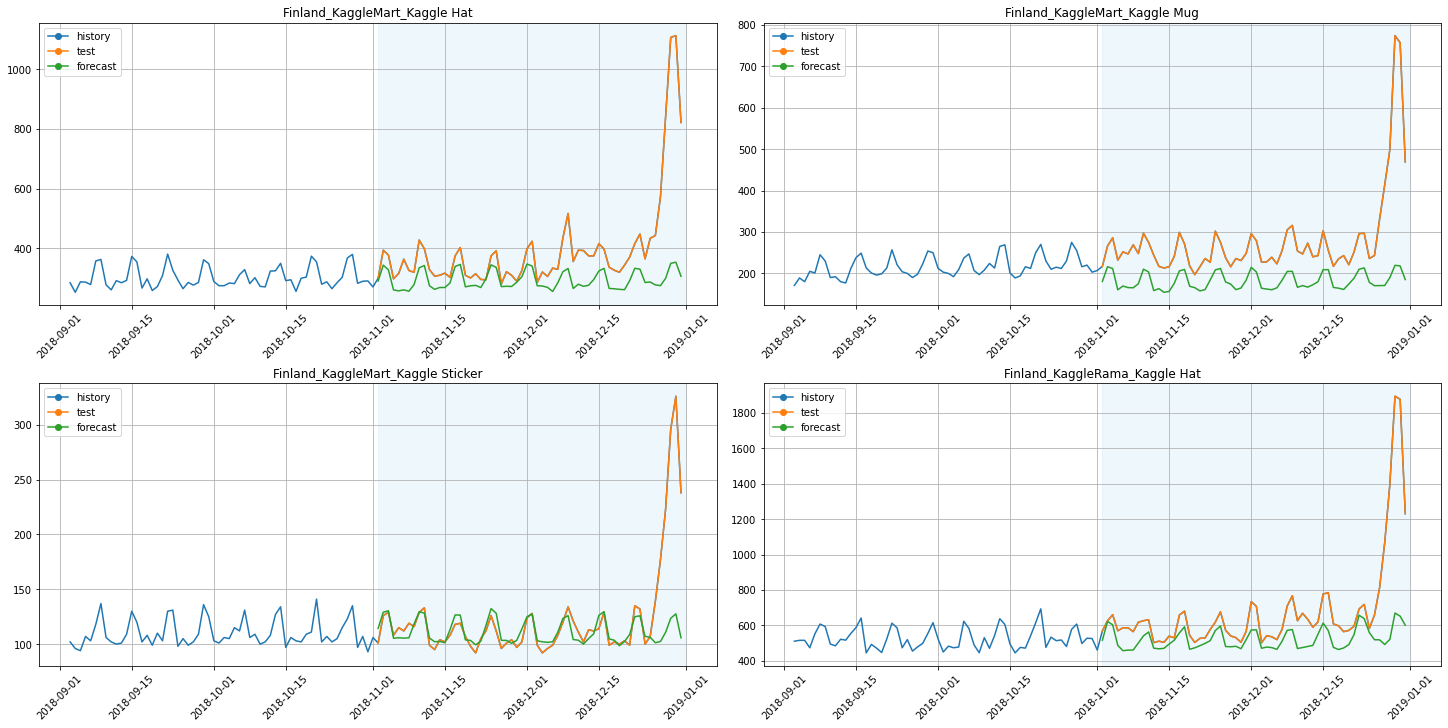

In [11]:
from etna.analysis import plot_backtest

plot_backtest(forecast_baseline, ts, history_len=60, segments=ts.segments[:4])

Now our pipeline has too much features, takes a lot of time for fit and predict methods and shows not perfect metrics. ETNA provides some methods to optimize this situation by removing some features:

### 2.1 TreeFeatureSelectionTransform

This method use tree-based model to estimate importance of each feature. After that method leaves `top_k` best features. This class accepts as input the next parameters:

1. model (model for estimating feature importance. Must have `fit` method and `feature_importances_` parameter)
2. top_k (number of features to select)
3. features_to_use (which features participate in feature selection)
4. return_features (return_features indicates whether to save features or not. It's important if you want to return your initial features with method `inverse_transform` after feature selection)

Let's optimize our baseline:

In [29]:
from etna.transforms import TreeFeatureSelectionTransform, LagTransform, DateFlagsTransform
from sklearn.tree import DecisionTreeRegressor

model_feature_selection = DecisionTreeRegressor(random_state=42)
feature_selector_transform = TreeFeatureSelectionTransform(
    model=model_feature_selection, top_k=10, return_features=True
)

pipeline = Pipeline(
    model=CatBoostModelPerSegment(), transforms=transforms + [feature_selector_transform], horizon=HORIZON
)
metrics_tree_feature_selector, forecast_tree_feature_selector, _ = pipeline.backtest(
    ts=ts, metrics=[SMAPE()], n_folds=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.3s finished


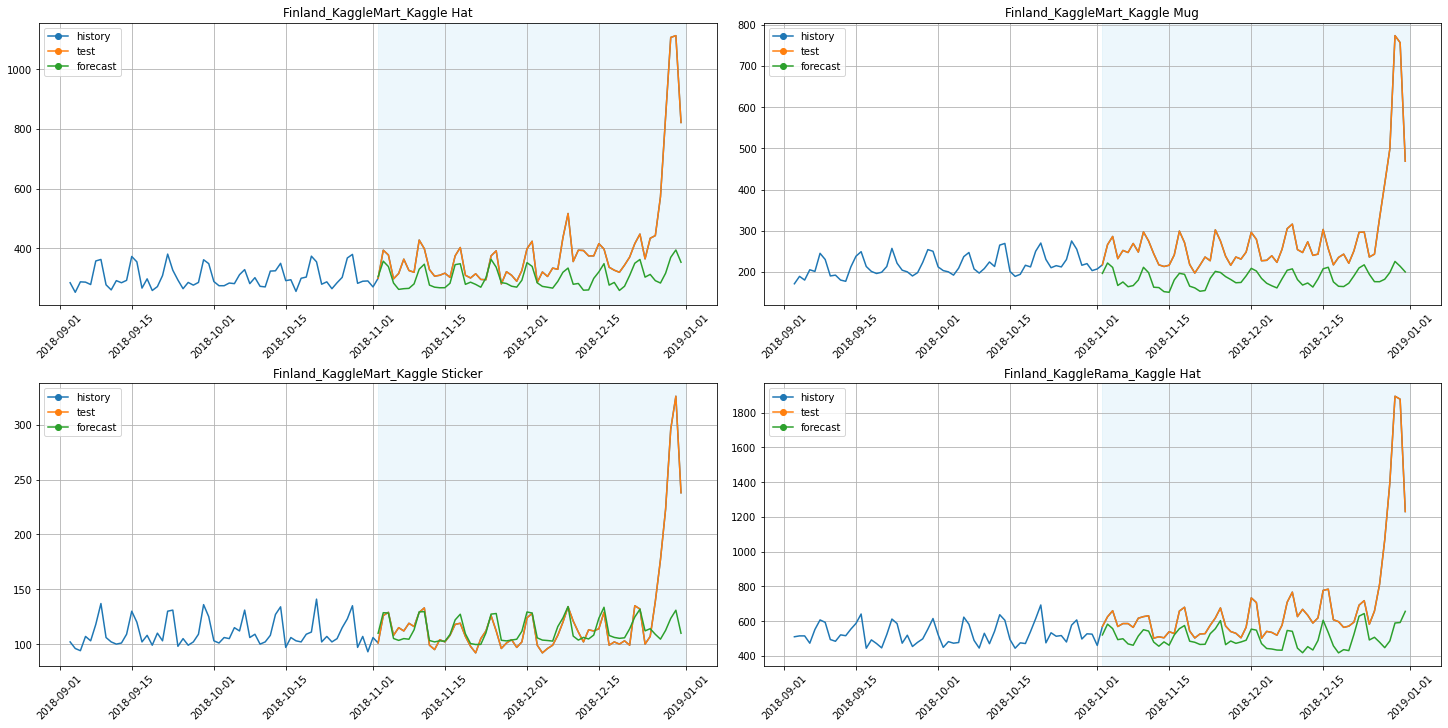

In [30]:
from etna.analysis import plot_backtest

plot_backtest(forecast_tree_feature_selector, ts, history_len=60, segments=ts.segments[:4])

Let's look whether metrics had improved or not:

In [31]:
(metrics_tree_feature_selector["SMAPE"].mean() / metrics_baseline["SMAPE"].mean())

1.0062064284566055

With this simple transform we improved SMAPE and backtest time in more than twice.

ETNA also provides methods to plot importance of each feature:

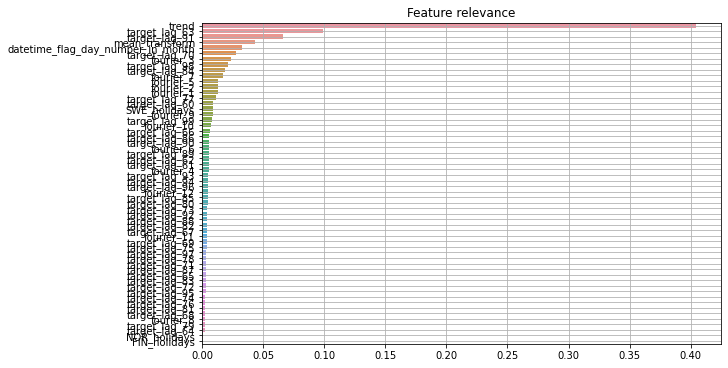

In [16]:
from etna.analysis import plot_feature_relevance
from etna.analysis.feature_relevance import RelevanceTable, ModelRelevanceTable

feature_selector_transform = TreeFeatureSelectionTransform(
    model=model_feature_selection, top_k=25, return_features=True
)
ts.fit_transform(transforms=transforms)

plot_feature_relevance(ts, relevance_table=ModelRelevanceTable(), relevance_params={"model": model_feature_selection})
ts.inverse_transform()

### 2.2 GaleShapleyFeatureSelectionTransform

#### Idea of this transform:

Let we have table with size $features \times segments$ ($features$ - number of features, $segments$ - number of segments) with relevances. Filtering features consist of $\frac{k}{segments}$ iterations. In each iteration we build matching with gale-shapley algorithm ([here](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) you can read more about this algorithm), add result pairs (segment, feature) to the answer, delete them from the table and continue while we don't get $k$ features for each segment.

In ETNA there is `StatisticsRelevanceTable` to get this table. You can get table with p-values by calling method `__call__` in this class

In [17]:
from etna.transforms import GaleShapleyFeatureSelectionTransform
from etna.analysis.feature_relevance import StatisticsRelevanceTable

rt = StatisticsRelevanceTable()
feature_selector_transform = GaleShapleyFeatureSelectionTransform(top_k=10, relevance_table=rt, return_features=True)


pipeline = Pipeline(
    model=CatBoostModelPerSegment(), transforms=transforms + [feature_selector_transform], horizon=HORIZON
)
metrics_galeshapley_feature_selector, forecast_galeshapley_feature_selector, _ = pipeline.backtest(
    ts=ts, metrics=[SMAPE()], n_folds=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 41.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 41.3min finished


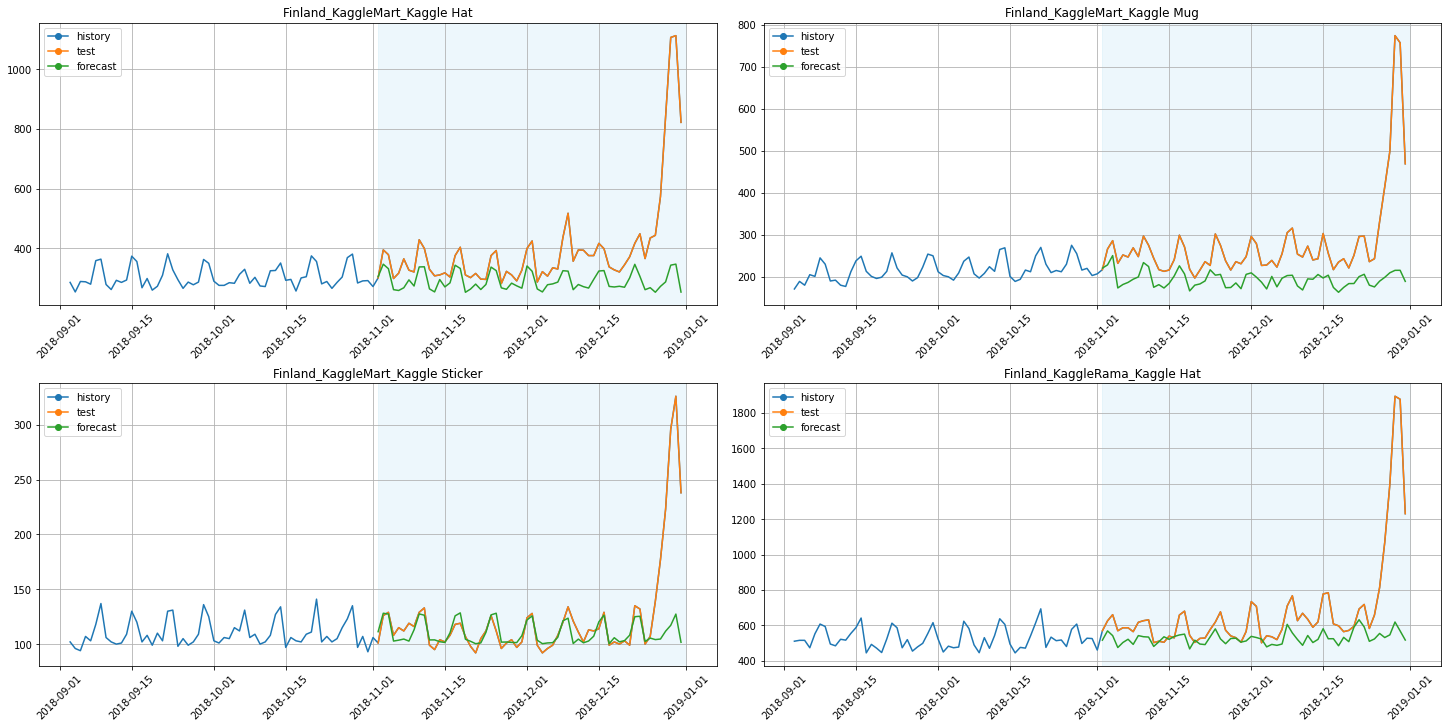

In [18]:
plot_backtest(forecast_galeshapley_feature_selector, ts, history_len=60, segments=ts.segments[:4])

In [24]:
(metrics_galeshapley_feature_selector["SMAPE"].mean() / metrics_baseline["SMAPE"].mean())

1.015716216342101

### 2.3 MRMRFeatureSelectionTransform

#### Intuition

Let we have features `A`, `B` and `C`. `A` and `B` will be more relevant to target function (criterion of relevance will be discussed later) than `C`, but `A` and `B` are correlated, that is `B` gives not too much new information with `A`. Simple feature selection algorithm will choose `A` and `B` features as more informative, but MRMR will choose (`A`, `C`) or (`B`, `C`). That's why this method stands for "Maximum Relevance - Minimum Redundancy". 

All algorithm consists of iterative choosing such features, which are informative for target and not correlated with other selected features. Criterion of Relevance and will be F-statistic and Pearson correlation respectively.

#### More formally

This algorithm iteratively finds best feature from non-selected features by some rule. This rule is to choose best feature $f$ by the next metric:

### $metic(f) = \frac{relevance(f | target)}{redundancy(f | previous)} = \frac{F(f, target)}{\sum_{s \in previous} |corr(f, s)|} \cdot (i-1)$

Where `previous` is previous selected features, `F` is F-statistic and `corr` is Pearson correlation, `i` is iteration.

Let's look at example of usage:

In [20]:
from etna.transforms.feature_selection import MRMRFeatureSelectionTransform
from etna.analysis.feature_relevance import StatisticsRelevanceTable

rt = StatisticsRelevanceTable()
feature_selector_transform = MRMRFeatureSelectionTransform(top_k=10, relevance_table=rt, return_features=True)

pipeline = Pipeline(
    model=CatBoostModelPerSegment(), transforms=transforms + [feature_selector_transform], horizon=HORIZON
)
metrics_mrmr_feature_selector, forecast_mrmr_feature_selector, _ = pipeline.backtest(
    ts=ts, metrics=[SMAPE()], n_folds=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 44.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 44.1min finished


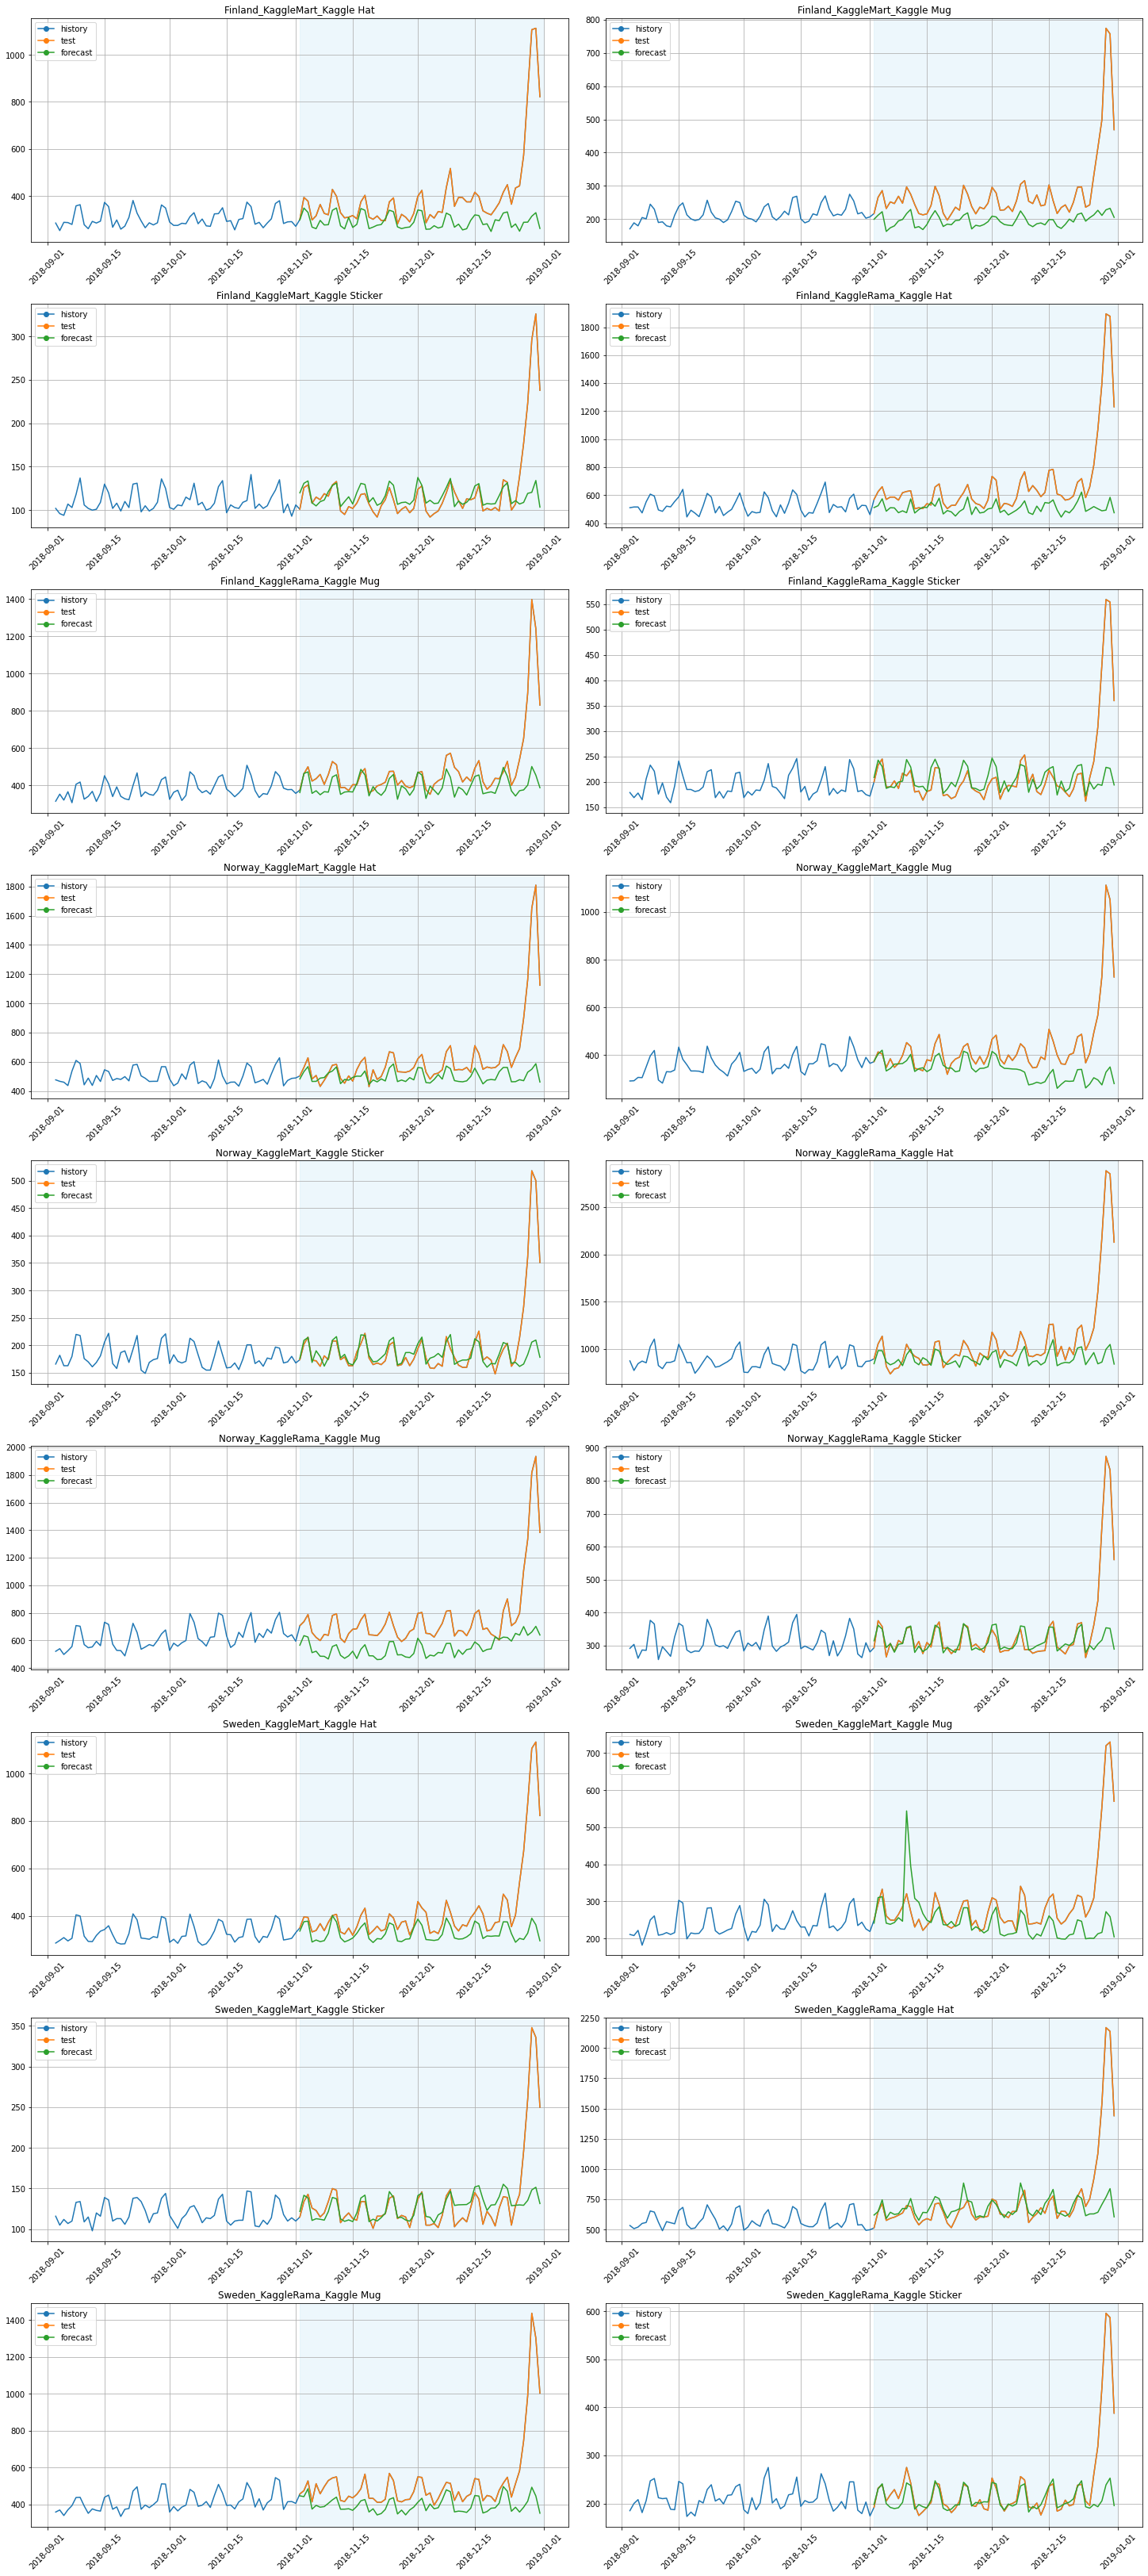

In [21]:
plot_backtest(forecast_mrmr_feature_selector, ts, history_len=60)

In [23]:
(metrics_mrmr_feature_selector["SMAPE"].mean() / metrics_baseline["SMAPE"].mean())

1.0004217088748883

## Summary

In this notebook we have checked some methods of feature selection. As we have seen, such tricks usually improve metrics and can decrease runtime of your pipeline.